# [빅데이터 분석과 응용] 기말 프로젝트
## 드라마 자원 추천 시스템
### MBA조 (이지희, 김나영, 강하연, 오현영)

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import Image
import requests
import re
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
import matplotlib 

## 1. 데이터 가져오기 

In [2]:
df = pd.read_csv('./Drama_List_final.csv')
df[:5]

,Unnamed: 0,Title_english,Rating,Genre,Title_korean,Synopsis,Actor,Director,Writer,Tags,Images,Watchers
0,0,Move to Heaven,9.2,"Life, Drama, Family",무브 투 헤븐: 나는 유품정리사입니다,Han Geu Roo is a 20-year-old with Autism. He w...,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...",Kim Sung Ho,Yoon Ji Ryun,"Uncle-Nephew Relationship, Autism, Death, Sava...",https://i.mydramalist.com/Rle36_4c.jpg?v=1,47482
1,1,Hospital Playlist,9.1,"Friendship, Romance, Life, Medical",슬기로운 의사 생활,The stories of people going through their days...,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",Lee Woo Jung,Shin Won Ho,"Multiple Mains, Best Friends, Hospital, Slow R...",https://i.mydramalist.com/RXXL6_4c.jpg?v=1,68688
2,2,Flower of Evil,9.1,"Thriller, Romance, Crime, Melodrama",악의 꽃,Although Baek Hee Sung is hiding a dark secret...,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Yoo Jung Hee,Kim Chul Gyu,"Married Couple, Deception, Family Secret, Susp...",https://i.mydramalist.com/WAEAp_4c.jpg?v=1,73946
3,3,Hospital Playlist 2,9.1,"Friendship, Romance, Life, Medical",슬기로운 의사생활++,Everyday is extraordinary for five doctors and...,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",Lee Woo Jung,Shin Won Ho,"Workplace, Strong Friendship, Best Friends, Mu...",https://i.mydramalist.com/dKY0d_4c.jpg?v=1,34295
4,4,My Mister,9.1,"Psychological, Life, Drama, Family",나의 아저씨,Park Dong Hoon is a middle-aged engineer who i...,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Park Hae Young,Kim Won Suk,"Nice Male Lead, Strong Female Lead, Smart Fema...",https://i.mydramalist.com/2lb8k_4c.jpg?v=1,51608


In [3]:
# cleaned'라는 새로운 열에 저장

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Synopsis'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [4]:
# Nan값으로 바꾸어
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 694


In [5]:
#문서별 번호 다시 정렬
df = df.reset_index()
df[:5]

,index,Unnamed: 0,Title_english,Rating,Genre,Title_korean,Synopsis,Actor,Director,Writer,Tags,Images,Watchers,cleaned
0,0,0,Move to Heaven,9.2,"Life, Drama, Family",무브 투 헤븐: 나는 유품정리사입니다,Han Geu Roo is a 20-year-old with Autism. He w...,"Lee Je Hoon, Tang Jun Sang, Hong Seung Hee, Ju...",Kim Sung Ho,Yoon Ji Ryun,"Uncle-Nephew Relationship, Autism, Death, Sava...",https://i.mydramalist.com/Rle36_4c.jpg?v=1,47482,han geu roo year old autism works fathers busi...
1,1,1,Hospital Playlist,9.1,"Friendship, Romance, Life, Medical",슬기로운 의사 생활,The stories of people going through their days...,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",Lee Woo Jung,Shin Won Ho,"Multiple Mains, Best Friends, Hospital, Slow R...",https://i.mydramalist.com/RXXL6_4c.jpg?v=1,68688,stories people going days seemingly ordinary a...
2,2,2,Flower of Evil,9.1,"Thriller, Romance, Crime, Melodrama",악의 꽃,Although Baek Hee Sung is hiding a dark secret...,"Lee Joon Gi, Moon Chae Won, Jang Hee Jin, Seo ...",Yoo Jung Hee,Kim Chul Gyu,"Married Couple, Deception, Family Secret, Susp...",https://i.mydramalist.com/WAEAp_4c.jpg?v=1,73946,although baek hee sung hiding dark secret surr...
3,3,3,Hospital Playlist 2,9.1,"Friendship, Romance, Life, Medical",슬기로운 의사생활++,Everyday is extraordinary for five doctors and...,"Jo Jung Suk, Yoo Yeon Seok, Jung Kyung Ho, Kim...",Lee Woo Jung,Shin Won Ho,"Workplace, Strong Friendship, Best Friends, Mu...",https://i.mydramalist.com/dKY0d_4c.jpg?v=1,34295,everyday extraordinary five doctors patients i...
4,4,4,My Mister,9.1,"Psychological, Life, Drama, Family",나의 아저씨,Park Dong Hoon is a middle-aged engineer who i...,"Lee Sun Kyun, IU, Park Ho San, Song Sae Byuk, ...",Park Hae Young,Kim Won Suk,"Nice Male Lead, Strong Female Lead, Smart Fema...",https://i.mydramalist.com/2lb8k_4c.jpg?v=1,51608,park dong hoon middle aged engineer married at...


In [6]:
# 수행 결과 확인
df['cleaned'][:5]

0    han geu roo year old autism works fathers busi...
1    stories people going days seemingly ordinary a...
2    although baek hee sung hiding dark secret surr...
3    everyday extraordinary five doctors patients i...
4    park dong hoon middle aged engineer married at...
Name: cleaned, dtype: object

In [7]:
# 토큰화를 수행하여 corpus라는 리스트에 저장함. corpus로 Word2Vec을 훈련할 예정

corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

## 2. 사전 훈련된 워드 임베딩 가져와 사용하기

In [8]:
# 이 경우는 데이터가 충분치 않아서 구글에서 제공하는 모델을 사용하고자 함
import gensim.downloader as api

word2vec_model = api.load('word2vec-google-news-300')

## 3. 단어 벡터의 평균 구하기
- 각 문서에 존재하는 단어들의 벡터값의 평균을 구하여 해당 문서의 벡터값을 계산

In [11]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.index_to_key:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더함
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠줌
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [12]:
document_embedding_list = get_document_vectors(df['cleaned'])
print(document_embedding_list)
print('문서 벡터의 수 :',len(document_embedding_list))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 4. 추천 시스템 구현하기
- 입력한 드라마의 줄거리와 가장 유사한 드라마을 추천하는 것을 목표로 함

In [13]:
# 각 문서 벡터 간 코사인 유사도를 계산
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (694, 694)


In [16]:
#한글 폰트 설정
font_location = '/System/Library/Fonts/Supplemental/AppleGothic.ttf' # C:/Windows/Fonts/NanumGothic.ttf
font_name = fm.FontProperties(fname = font_location).get_name()
plt.rc('font', family = font_name)
plt.rc('font', size=15)

In [17]:
def recommendations(title):
    drama= df[['Title_korean', 'Images']]
    

    # 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['Title_korean']).drop_duplicates()    
    idx = indices[title]

    # 입력된 드라마와 줄거리(document embedding)가 유사한 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    
    # 가장 유사한 드라마 5편의 인덱스
    drama_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = drama.iloc[drama_indices].reset_index(drop=True)
    fig = plt.figure(figsize=(20, 30))
    
    global recommend_list
    recommend_list = []
    for title in recommend['Title_korean']:
        recommend_list.append(str(title))
    
    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['Images'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['Title_korean'])

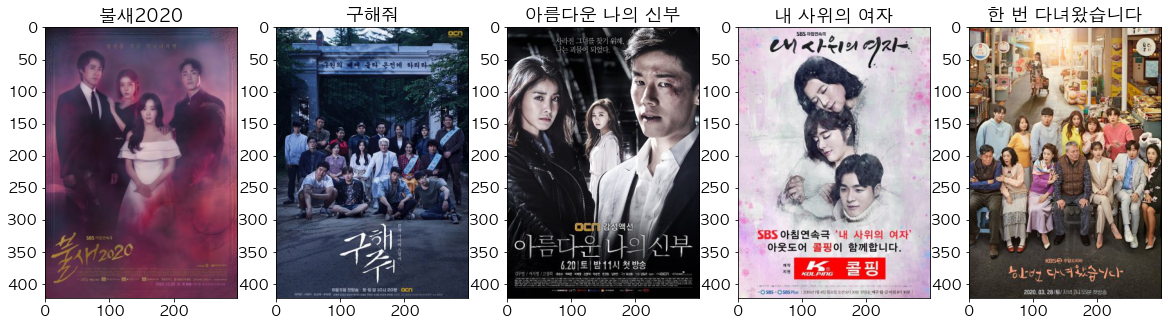

In [18]:
recommendations("나의 아저씨")

In [19]:
drama_info = df.loc[df['Title_korean'].isin(recommend_list)]
drama_info.iloc[:, 3:14]

,Rating,Genre,Title_korean,Synopsis,Actor,Director,Writer,Tags,Images,Watchers,cleaned
66,8.6,"Comedy, Romance, Drama, Family",한 번 다녀왔습니다,"""Once Again"" is the story of the eventful Song...","Chun Ho Jin, Cha Hwa Yun, Lee Jung Eun, Oh Dae...",Lee Jae Sang,Yang Hee Seung,"Divorce, Multiple Couples, Multiple Mains, Mar...",https://i.mydramalist.com/kWPprc.jpg?v=1,10101,once again story eventful song family cant get...
74,8.6,"Action, Thriller, Mystery, Drama",구해줘,Following the failure of her father's business...,"Seo Yea Ji, Ok Taec Yeon, Woo Do Hwan, Jo Sung...",Jung Yi Do,Kim Sung Soo,"Cult, Adapted From A Webtoon, Church, Strong F...",https://i.mydramalist.com/jW1jdc.jpg?v=1,48822,following failure father s business sang mi fa...
305,7.9,"Action, Mystery, Romance, Crime",아름다운 나의 신부,"Kim Do Hyung, who works as a bank executive an...","Kim Mu Yeol, Lee Si Young, Go Sung Hee, Ryu Se...",Yoo Sung Yeol,Kim Chul Gyu,"Gangster Supporting Character, Police Officer ...",https://i.mydramalist.com/vobL2c.jpg?v=1,8020,kim hyung works bank executive comes well to d...
643,7.3,"Romance, Drama, Family, Melodrama",내 사위의 여자,Lee Jin Sook is a speaker on family happiness....,"Seo Ha Joon, Yang Jin Sung, Park Soon Chun, J...",Ahn Seo Jung,Ahn Gil Ho,"Single Father, Nice Female Lead, Soap Opera, P...",https://i.mydramalist.com/Q2XLWc.jpg?v=1,553,lee jin sook speaker family happiness however ...
682,6.6,"Business, Romance, Drama, Melodrama",불새2020,Belonging to the wealthiest class and as the d...,"Hong Soo Ah, Lee Jae Woo, Seo Ha Joon, Park Yo...",Lee Hyun Jik,Lee Yoo Jin,"Disapproving Parent, Time Skip, Divorce, Famil...",https://i.mydramalist.com/ENyR0_4c.jpg?v=1,1061,belonging wealthiest class daughter influentia...


In [20]:
print(recommend_list)

['불새2020', '구해줘', '아름다운 나의 신부', '내 사위의 여자', '한 번 다녀왔습니다']


In [21]:
drama_comment = []

# 특정 환경에서만 작동
def get_comment(drama_name):
    driver = webdriver.Chrome(ChromeDriverManager().install())
    url = 'https://mydramalist.com'

    driver.get(url)
    driver.maximize_window()

    driver.implicitly_wait(3)
    inputElement = driver.find_element_by_class_name('form-control.p-x.b-a.rounded')
    #inputElement = driver.find_element_by_name('q')
    print(inputElement)
    inputElement.send_keys(drama_name)
    time.sleep(1)

    inputElement.submit()

    div = driver.find_element_by_class_name('text-primary.title')
 
    href = div.find_element_by_css_selector('a')


    href.click()

    driver.implicitly_wait(3)


    last_height = driver.execute_script("return document.body.scrollHeight")

    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        driver.implicitly_wait(3)

        new_height = driver.execute_script("return document.body.scrollHeight") 
        if new_height == last_height:
            break
        last_height = new_height

        try:
            moreButton = driver.find_element_by_css_selector('button.el-button.btn.btn-block.btn-default.el-button--default')
            print(moreButton)

            driver.execute_script("arguments[0].send_keys();", moreButton)
            #moreButton.click()
            driver.implicitly_wait(3)
        except:
            break
            


    #print('LOAD POST MESSAGE')
    postLists = driver.find_elements_by_xpath("//div[@class='post-message']")
    print(postLists)
   
    for postTag in postLists:
        try:
            postMessage = postTag.find_element_by_css_selector('p')
            print(postMessage.text)
            drama_comment.append(postMessage.text)
        except:
            pass
    return drama_comment

몇 번째 드라마의 속성을 확인하시겠습니까?1




====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [/Users/hayeon/.wdm/drivers/chromedriver/mac64/102.0.5005.61/chromedriver] found in cache


<selenium.webdriver.remote.webelement.WebElement (session="4a04ab2dd7bb0716ff4205f8b21ae230", element="b60d21be-35e3-47d6-b384-08312db2dc76")>
[<selenium.webdriver.remote.webelement.WebElement (session="4a04ab2dd7bb0716ff4205f8b21ae230", element="cb029b4c-2b9b-4bc8-af1e-43d327451220")>, <selenium.webdriver.remote.webelement.WebElement (session="4a04ab2dd7bb0716ff4205f8b21ae230", element="124c40c2-b837-4f41-bf3f-92e529b27067")>, <selenium.webdriver.remote.webelement.WebElement (session="4a04ab2dd7bb0716ff4205f8b21ae230", element="53c19f24-a2dd-4829-afe1-8baa3c76a016")>, <selenium.webdriver.remote.webelement.WebElement (session="4a04ab2dd7bb0716ff4205f8b21ae230", element="8dd0ee8e-f188-41d9-8d79-2b3ee0782a00")>, <selenium.webdriver.remote.webelement.WebElement (session="4a04ab2dd7bb0716ff4205f8b21ae230", element="76c795fa-bc6a-404b-8946-f239b833fe77")>, <selenium.webdriver.remote.webelement.WebElement (session="4a04ab2dd7bb0716ff4205f8b21ae230", element="5e212e13-4557-49ea-a9cf-38243b563

<ipython-input-62-1388d65488a0>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df_comment['comment'] = df_comment['comment'].str.replace('[^a-zA-Z]',' ')


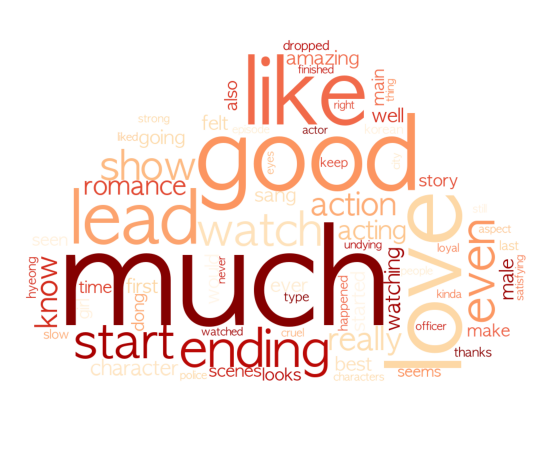

In [62]:
number = int(input("몇 번째 드라마의 속성을 확인하시겠습니까?"))
# 특정 환경에서만 작동

comment_list = get_comment(recommend_list[number])
df_comment = pd.DataFrame(data = [[(','.join(comment_list))]], columns=['comment'])
print(df_comment)

df_comment['comment'] = df_comment['comment'].str.replace('[^a-zA-Z]',' ') 
df_comment['comment'] = df_comment['comment'].str.lower()

comment =  df_comment['comment'].to_list()

stop_words = set(stopwords.words('english')) 
word_tokens = word_tokenize(comment[0])
result = []
       

# ps = PorterStemmer()
for w in word_tokens:
# w = ps.stem(w)
    if w not in stop_words: 
        result.append(w) 
print(len(result))

comment = []
for i in range(len(result)):
    if not 'drama' in result[i]:
        comment.append(result[i])

# 세 글자 이하의 단어 제거
comment_result = []
for s in comment:
    if len(s) > 3:
        comment_result.append(s)

print(comment_result)

counts = Counter(comment_result)
tags = counts.most_common(70)
tags

wordcloud = WordCloud(font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                 background_color = 'black', width = 1000, height = 500)
print(dict(tags))

cloud_mask = np.array(Image.open("/Users/hayeon/Downloads/cloud.png")) # C:\\Users\\User\\Documents\\카카오톡 받은 파일\\cloud.png
wordcloud = WordCloud(font_path = '/System/Library/Fonts/Supplemental/AppleGothic.ttf',
                 background_color = 'white', width=900, height = 800, colormap='OrRd', mask=cloud_mask)
print(dict(tags))

cloud = wordcloud.generate_from_frequencies(dict(tags))
plt.figure(figsize = (10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

## 배우명과 하트 수 크롤링

In [63]:
Name = []
Hearts = []

In [64]:
pre ='https://mydramalist.com/search?adv=people&na=3&so=popular&page='

#site_pre = 'https://mydramalist.com/search?adv=people&na=3&so=popular&page='
Actor = []
Hearts = []
for i in range(1,250) :
    site = pre + str(i)
    res = requests.get(site)
    soup = BeautifulSoup(res.content)
    
    data_name = soup.find_all("h6","text-primary title")
    for a in data_name:
        Actor.append(a.get_text().strip())
        
    counts_hearts = soup.find_all("span","like-cntb")    
    for b in counts_hearts:
        Hearts.append(b.get_text().strip())
   
    

/Users/hayeon/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:177: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 194 of the file /Users/hayeon/opt/anaconda3/lib/python3.8/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  warnings.warn(self.NO_PARSER_SPECIFIED_WARNING % dict(


In [65]:
df_actor = pd.DataFrame({'배우명' : Actor, '하트 수': Hearts })
df_actor[:5]

,배우명,하트 수
0,Lee Min Ho,"12,848"
1,Lee Jong Suk,"18,588"
2,Park Shin Hye,"10,038"
3,Ji Chang Wook,"14,940"
4,Song Joong Ki,"12,835"


In [66]:
#csv파일로 저장
df_actor.to_csv('Actor.csv')

## 드라마 출연진 리스트 받기
- 각 배우명을 칼럼화하여 리스트로 받기

In [67]:
def get_Actorlist(DramaName):
    drama = df.loc[(df['Title_korean'] == DramaName)]
    target = drama['Actor']
    Actor_dummy = drama['Actor'].str.get_dummies(sep = ', ')
    TargetActors = Actor_dummy.columns
    return TargetActors

In [68]:
#드라마 제목 입력
Actorlist = get_Actorlist(recommend_list[number])
Actorlist

Index(['Bae Gi Beom', 'Choi Hyuk Joo', 'Choi Moon Soo', 'David Lee', 'Go Jun',
       'Ha Hoe Jung', 'Jang Hyuk Jin', 'Jang Won', 'Jang Yoo Sang',
       'Jeon Yeo Been', 'Jo Jae Yoon', 'Jo Sung Ha', 'Jung Hae Kyun',
       'Jung Jae Kwang', 'Jung Ji Ho', 'Jung Joon Won ', 'Kang Deok Joong',
       'Kang Kyung Hun', 'Kim Kwang Gyu', 'Lee  Jae Joon', 'Lee In Chul',
       'Lee Jung Hun', 'Lee Kyung Hoon', 'Lee Seung Hyub', 'Lee Tae Hyung',
       'Min Kyung Ok', 'Ok Taec Yeon', 'Park Ji Young', 'Park Soo Yeon',
       'Seo Yea Ji', 'Son Byung Ho', 'Son Byung Wook', 'Son Sang Kyung',
       'Woo Do Hwan', 'Yoon Jong Seok', 'Yoon Yoo Sun'],
      dtype='object')

# 배우별 인기를 확인하는 그래프

In [69]:
df_actor = pd.read_csv('Actor.csv')

In [70]:
#그래프를 만들기 위해 하트 수를 정수형으로 변환함
df_actor['하트 수'] = df_actor['하트 수'].str.replace(',','').astype('int')

                  배우명  하트 수  Unnamed: 0
159        Seo Yea Ji  5022       159.0
500       Woo Do Hwan  4713       500.0
65       Ok Taec Yeon  4300        65.0
4757    Jeon Yeo Been  1219      4757.0
471         David Lee   491       471.0
667       Jo Jae Yoon   463       667.0
367     Lee  Jae Joon   398       367.0
2204           Go Jun   328      2204.0
792     Kim Kwang Gyu   303       792.0
2256   Lee Seung Hyub   283      2256.0
695        Jo Sung Ha   219       695.0
576     Jang Yoo Sang   183       576.0
658     Park Ji Young   182       658.0
819      Yoon Yoo Sun   167       819.0
4929   Yoon Jong Seok   155      4929.0
1850    Jang Hyuk Jin   126      1850.0
1365    Jung Hae Kyun    97      1365.0
1667     Son Byung Ho    42      1667.0
4624      Ha Hoe Jung    17      4624.0
2114   Kang Kyung Hun    10      2114.0
3044    Choi Moon Soo     7      3044.0
4156  Kang Deok Joong     4      4156.0
3267   Son Byung Wook     4      3267.0
3968   Son Sang Kyung     4      3968.0


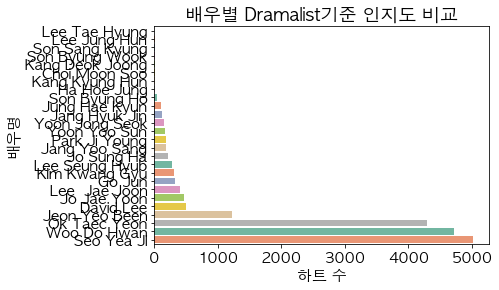

In [72]:
df_target = pd.DataFrame(columns = ['배우명', '하트 수'])

for i in range(len(Actorlist)):
    df_2=df_actor.loc[(df_actor['배우명'] == Actorlist[i])]
    df_target=df_target.append(df_2)

print(df_target.sort_values('하트 수', ascending = False))

sns.barplot(data=df_target, x=df_target.sort_values('하트 수')['하트 수'], y=df_target.sort_values('하트 수')['배우명'], palette='Set2')
plt.title('배우별 Dramalist기준 인지도 비교')
plt.show()